In [1]:
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


# Below plots are based on Tensorboard logs (not based on every iteration)

## Uncomment this in case csv files are not available

# Below plots are based on .pkl files as they are plotted based on each iteration

In [5]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)

softmatch = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/reset32_scaler_4_d3b0e90.pkl') # best_st_plot_60c84b7
softmatch_weights = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_0.5.pkl')
iou3d = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# iou3d = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/3diou.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# iou3d_old_thresh = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/iou3d_old_thresh2.pkl') 
# This is based on FG+UC+BG with class agnostic local thresholds , it needs a re-run to get the correct class agnostic scores based on UC_FP+BG
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/a8_scores.pkl') 
ablation1_df = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl') 


df2 =  pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl')
scores_6 = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_6.pkl')
subsample = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/subsample.pkl')

## (Fig 1) Need of classwise thresholds

#### Separating TP and FNs

6


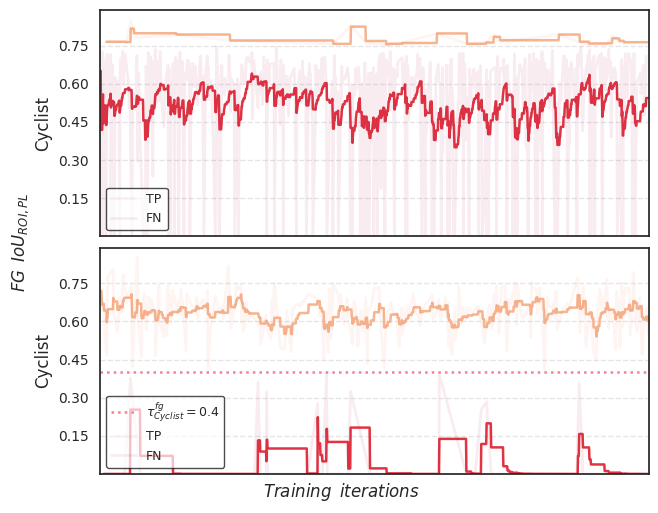

In [6]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}

    p = sns.color_palette('rocket')
    q = sns.color_palette("husl", 8)
    print(len(p))
    palette = {'Car': q[5], 'Pedestrian':q[3], 'Cyclist': q[0]}
    # palette = {'Car': p[-2], 'Pedestrian':p[-1], 'Cyclist': p[2]}

    for j in range(2):
        df = dfs[j]
        x = 1
        tp_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
        tp_iou_roi_pl_df['Car'] = np.nan
        tp_iou_roi_pl_df['Pedestrian'] = np.nan
        tp_iou_roi_pl_df['Cyclist'] = np.nan

        fn_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
        fn_iou_roi_pl_df['Car'] = np.nan
        fn_iou_roi_pl_df['Pedestrian'] = np.nan
        fn_iou_roi_pl_df['Cyclist'] = np.nan
        #Enter and Nan initialize values so far

        d = {3: 'Cyclist'}
        for cls_idx, cls_name in d.items():
            cls_mask = torch.Tensor(df['class_labels'])==cls_idx                # filter class
            fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]    # filter FG ROIs wrt GT
            valid_mask = cls_mask & fg_mask

            aux_df = pd.DataFrame()
            aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
            aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
        
            fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()      # get mean FG IoU per iteration
            for idx, _ in tp_iou_roi_pl_df.iterrows():
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                    # Filter TP and FN IoUs
                    if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0] > thresh[j][cls_idx-1]:
                        tp_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]
                    else:
                        fn_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

            # plot threshold lines 
            if j == 0 and cls_idx == 2:
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\Delta=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                label = "$\\tau^{fg}_{cls}=thresh$".replace('cls', cls_name).replace('thresh', str(thresh[j][cls_idx-1]))
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)
    
        # plot ious
        tp_iou_roi_pl_df = tp_iou_roi_pl_df.drop(['iteration'], axis=1)
        fn_iou_roi_pl_df = fn_iou_roi_pl_df.drop(['iteration'], axis=1)
        ema_alpha = 0.05 if j==0 else 0.05 #0.01 if j==0 else 0.015
        ema_linewidth = 1.8 if j==0 else 1.8
        line_width = 2 if j==0 else 2
        sns.lineplot(ax=axes[j], data=tp_iou_roi_pl_df['Cyclist'].ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=tp_iou_roi_pl_df['Cyclist'], linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08, label='TP')

        sns.lineplot(ax=axes[j], data=fn_iou_roi_pl_df['Cyclist'].ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=fn_iou_roi_pl_df['Cyclist'], linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08, label='FN')

        # x/y ticks
        axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].tick_params(pad=2)
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # start the 0 of x axis form leftmost part of the plot 
        axes[j].set_xlim(left=0)
        axes[j].set_ylim(bottom=0)
        # remove extra white space at the end of x axis
        axes[j].set_xlim(right=1440/x)
        # # legends
        
        # handles, labels = axes[j].get_legend_handles_labels()
        legend = axes[j].legend(frameon = True, ncol=1, fontsize=9, framealpha = 0.7, loc="lower left")
        # order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        # ncol = 3 if j==1 else 4
        # if j==0:
        #     legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
        #                             frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        # else:
        #     legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
        #                             frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
    f.text(-0.01, 0.5, '$FG\enspaceIoU_{ROI, PL}$', va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()

#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [scores_6,subsample]
get_fg_iou_plot(dfs)

6


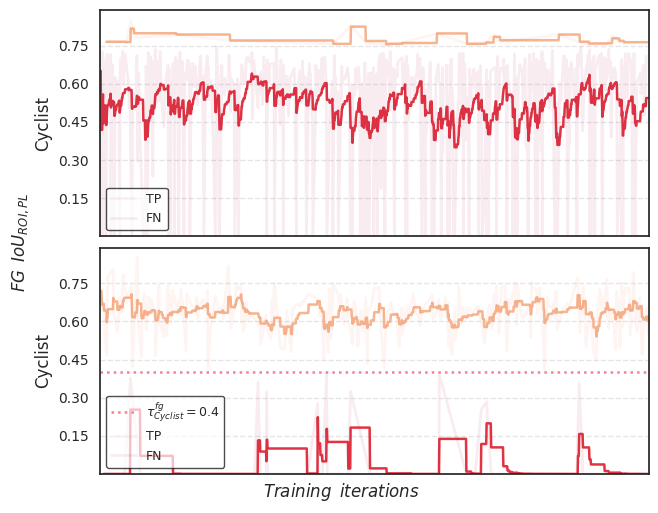

In [4]:
dfs = [scores_6,subsample]
sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                    'xtick.bottom': False,
                                                    'ytick.left': False,
                                                    })      
f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}

p = sns.color_palette('rocket')
q = sns.color_palette("husl", 8)
print(len(p))
palette = {'Car': q[5], 'Pedestrian':q[3], 'Cyclist': q[0]}
# palette = {'Car': p[-2], 'Pedestrian':p[-1], 'Cyclist': p[2]}

for j in range(2):
    df = dfs[j]
    x = 1
    tp_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
    tp_iou_roi_pl_df['Car'] = np.nan
    tp_iou_roi_pl_df['Pedestrian'] = np.nan
    tp_iou_roi_pl_df['Cyclist'] = np.nan

    fn_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
    fn_iou_roi_pl_df['Car'] = np.nan
    fn_iou_roi_pl_df['Pedestrian'] = np.nan
    fn_iou_roi_pl_df['Cyclist'] = np.nan

    d = {3: 'Cyclist'}
    for cls_idx, cls_name in d.items():
        cls_mask = torch.Tensor(df['class_labels'])==cls_idx                # filter class
        fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]    # filter FG ROIs wrt GT
        valid_mask = cls_mask & fg_mask

        aux_df = pd.DataFrame()
        aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
        aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
    
        fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()      # get mean FG IoU per iteration
        for idx, _ in tp_iou_roi_pl_df.iterrows():
            if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                # Filter TP and FN IoUs
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0] > thresh[j][cls_idx-1]:
                    tp_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]
                else:
                    fn_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

        # plot threshold lines 
        if j == 0 and cls_idx == 2:
            axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\Delta=0.75$", color='black', alpha=0.9, lw=1.8)
        if j == 1:
            label = "$\\tau^{fg}_{cls}=thresh$".replace('cls', cls_name).replace('thresh', str(thresh[j][cls_idx-1]))
            axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
        axes[j].yaxis.set_tick_params(labelleft=True)

    # plot ious
    tp_iou_roi_pl_df = tp_iou_roi_pl_df.drop(['iteration'], axis=1)
    fn_iou_roi_pl_df = fn_iou_roi_pl_df.drop(['iteration'], axis=1)
    ema_alpha = 0.05 if j==0 else 0.05 #0.01 if j==0 else 0.015
    ema_linewidth = 1.8 if j==0 else 1.8
    line_width = 2 if j==0 else 2
    sns.lineplot(ax=axes[j], data=tp_iou_roi_pl_df['Cyclist'].ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
    sns.lineplot(ax=axes[j], data=tp_iou_roi_pl_df['Cyclist'], linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08, label='TP')

    sns.lineplot(ax=axes[j], data=fn_iou_roi_pl_df['Cyclist'].ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
    sns.lineplot(ax=axes[j], data=fn_iou_roi_pl_df['Cyclist'], linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08, label='FN')

    # x/y ticks
    axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
    axes[j].tick_params(pad=2)
    axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
    axes[j].xaxis.set_tick_params(labelbottom=False)
    axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
    # start the 0 of x axis form leftmost part of the plot 
    axes[j].set_xlim(left=0)
    axes[j].set_ylim(bottom=0)
    # remove extra white space at the end of x axis
    axes[j].set_xlim(right=1440/x)
    # # legends
    
    # handles, labels = axes[j].get_legend_handles_labels()
    legend = axes[j].legend(frameon = True, ncol=1, fontsize=9, framealpha = 0.7, loc="lower left")
    # order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
    # ncol = 3 if j==1 else 4
    # if j==0:
    #     legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
    #                             frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
    # else:
    #     legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
    #                             frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')

# common plot labels
f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
f.text(-0.01, 0.5, '$FG\enspaceIoU_{ROI, PL}$', va='center', rotation='vertical')
f.tight_layout()
f.subplots_adjust(wspace=0.02, hspace=0.05)
f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
plt.show()

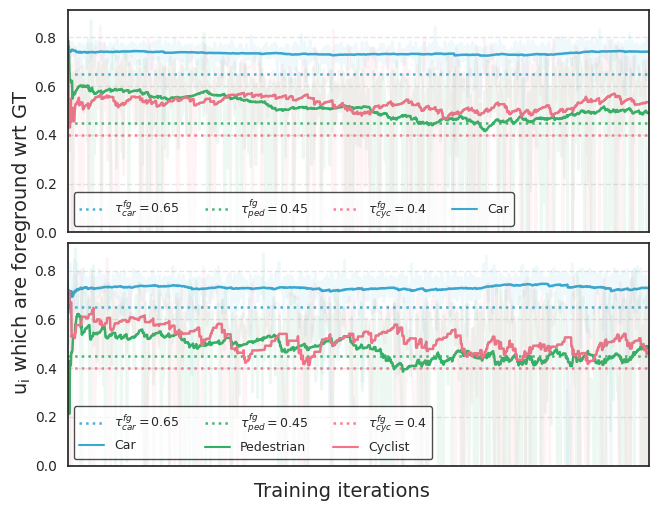

In [6]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.65,0.45,0.40], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}

    # p = sns.color_palette('rocket')
    q = sns.color_palette("husl", 8)
  
    palette = {'Car': q[5], 'Pedestrian':q[3], 'Cyclist': q[0]}
    # palette = {'Car': p[-2], 'Pedestrian':p[-1], 'Cyclist': p[2]}

    for j in range(2):
        df = dfs[j]
        x = 1
        fg_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
        fg_iou_roi_pl_df['Car'] = np.nan
        fg_iou_roi_pl_df['Pedestrian'] = np.nan
        fg_iou_roi_pl_df['Cyclist'] = np.nan

        for cls_idx, cls_name in num_to_class.items():
            cls_mask = torch.Tensor(df['class_labels'])==cls_idx
            fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]
            valid_mask = cls_mask & fg_mask

            aux_df = pd.DataFrame()
            aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
            aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
        
            fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()
            for idx, _ in fg_iou_roi_pl_df.iterrows():
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                    fg_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

            # plot threshold lines 
            # if j == 0 and cls_idx == 1:
            #     axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\tau^{fg}=0.75$", color='black', alpha=0.9, lw=1.8)
            # if j == 1:
            label = "$\\tau^{fg}_{cls}=thresh$".replace('cls', cls_name.lower()[:3]).replace('thresh', str(thresh[j][cls_idx-1]))
            axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)

        # plot ious
        fg_iou_roi_pl_df = fg_iou_roi_pl_df.drop(['iteration'], axis=1)
        ema_alpha = 0.01 if j==0 else 0.015
        ema_linewidth = 1.8 if j==0 else 1.8
        line_width = 2 if j==0 else 2
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df.ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df, linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08)

        # x/y ticks
        # axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].tick_params(pad=2)
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # start the 0 of x axis form leftmost part of the plot 
        axes[j].set_xlim(left=0)
        axes[j].set_ylim(bottom=0)
        # remove extra white space at the end of x axis
        axes[j].set_xlim(right=1440/x)
        # legends
        
        handles, labels = axes[j].get_legend_handles_labels()

        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4
        if j==0:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        else:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "Training iterations", ha='center', fontsize=14)
    f.text(-0.01, 0.5, '$\mathrm{u}_{\mathrm{i}}$ which are foreground wrt GT', va='center', rotation='vertical', fontsize=14)
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()

#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [scores_6,subsample]
get_fg_iou_plot(dfs)

In [7]:
a = np.asarray(softmatch_weights['ema_mean'])
np.nonzero(a==0)[0]

array([], dtype=int64)

In [132]:
sns.color_palette('rocket_r')

[(0.96516917, 0.70776351, 0.5606593),
 (0.95381595, 0.46373781, 0.31769923),
 (0.8833417, 0.19830556, 0.26014181),
 (0.67824099, 0.09192342, 0.3504148),
 (0.43860848, 0.12177004, 0.34119475),
 (0.20973515, 0.09747934, 0.24238489)]

6
['Car', 'Pedestrian', 'Cyclist', '$\\tau^{fg}=0.75$']
['Car', 'Pedestrian', 'Cyclist', '$\\tau^{fg}_{car}=0.65$', '$\\tau^{fg}_{ped}=0.45$', '$\\tau^{fg}_{cyc}=0.4$']


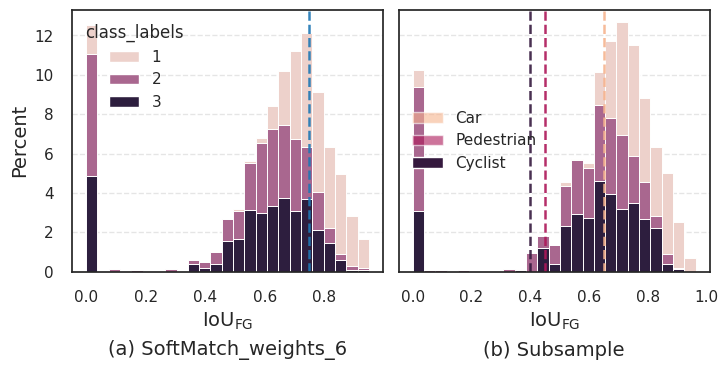

In [9]:
from matplotlib.patches import Rectangle
def get_equal_rows(df, num_rows):
    df = df.sort_values(by=['iteration'], ascending=False)
    df = df.reset_index(drop=True)
    equal_rows = []
    for cls in df['class_labels'].unique():
        equal_rows.append(df[df['class_labels']==cls][:num_rows])
    return pd.concat(equal_rows)

def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", rc={
                                    'xtick.bottom': False,
                                    'ytick.left': False,
                                    })      
    f, axes = plt.subplots(1, 2, sharey=True, figsize=(7.5,4))
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    p = sns.color_palette('rocket_r')
    print(len(p))
    palette = {'Car': p[0], 'Pedestrian':p[3], 'Cyclist': p[5]}
    # show me the above palette in the output



    for j in range(2):
        df = dfs[j]
        mask = (df['class_labels'] == 1) & (df['iou_roi_gt'] < fg_thresh[0]) | \
                (df['class_labels'] == 2) & (df['iou_roi_gt'] < fg_thresh[1]) | \
                (df['class_labels'] == 3) & (df['iou_roi_gt'] < fg_thresh[2])
        df = df[~mask]
        df = get_equal_rows(df, 500)

        sns.histplot(ax=axes[j], data=df, x="iou_roi_pl", hue="class_labels", fill=True, kde=False, multiple="stack", stat='percent', legend=True, bins=25, color=palette, alpha=1)

        if j==0:
            axes[j].axvline(x=0.75, linestyle="--", label="$\\tau^{fg}=0.75$", color=sns.color_palette("tab10")[0], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)
        else:
            axes[j].axvline(x=0.65, linestyle="--", label="$\\tau^{fg}_{car}=0.65$", color=palette['Car'], alpha=0.9, lw=1.8)
            axes[j].axvline(x=0.45, linestyle="--", label="$\\tau^{fg}_{ped}=0.45$", color=palette['Pedestrian'], alpha=0.9, lw=1.8)
            axes[j].axvline(x=0.4, linestyle="--", label="$\\tau^{fg}_{cyc}=0.4$", color=palette['Cyclist'], alpha=0.9, lw=1.8)
        
        axes[j].xaxis.set_tick_params(labelbottom=True)
        axes[j].set_xlabel('$\mathrm{IoU}_{\mathrm{FG}}$', fontsize=14)
        axes[j].set_ylabel('Percent', fontsize=14)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)

        handles1 = [Rectangle((0,0),1,1,color=palette['Car'],ec=None, alpha=0.6),
                    Rectangle((0,0),1,1,color=palette['Pedestrian'],ec=None, alpha=0.6),
                    Rectangle((0,0),1,1,color=palette['Cyclist'],ec=None, alpha=1)] 
        labels1= ["Car","Pedestrian", "Cyclist"]
        plt.legend(handles1, labels1)

        handles2, labels2 = axes[j].get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        print(labels)
        ncol = 1 if j==0 else 2
        order = [3,4,5,0,1,2] if j == 1 else [0,1,2,3]
        loc = "best" if j == 0 else "upper left"
        # legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon = True, ncol=ncol, fontsize=10, framealpha = 0.7, loc=loc)

        # frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
        # add subplot caption at bottom center of each plot
        axes[j].text(0.5, -0.30, f"({chr(97+j)}) {['SoftMatch_weights_6', 'Subsample'][j]}", ha='center', va='center', transform=axes[j].transAxes, fontsize=14)
    
    f.tight_layout()
    f.subplots_adjust(wspace=0.05, hspace=0.2)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()


_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in scores_6.items() ])) 
_ablation1_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in subsample.items() ])) 

# #! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [_ablation1_df, _df]
get_fg_iou_plot(dfs)

# Plot SoftMatch Metrics

6
6
6
6


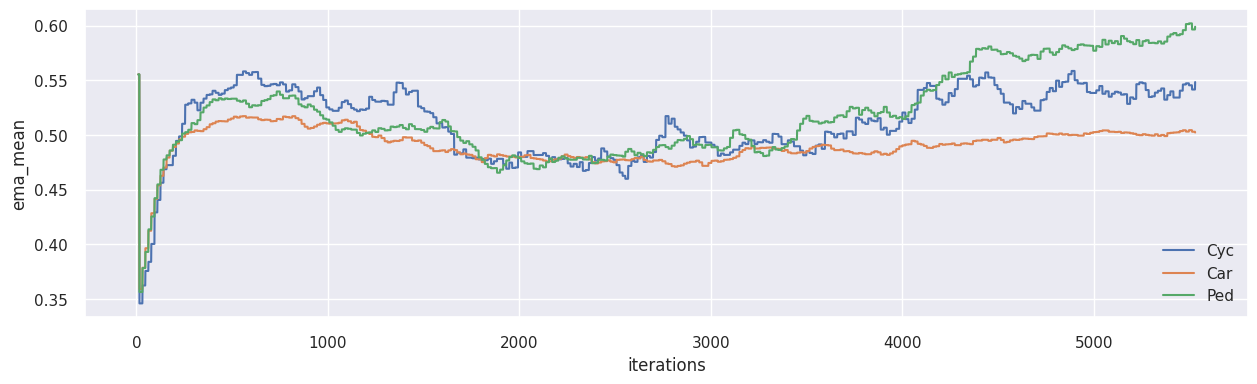

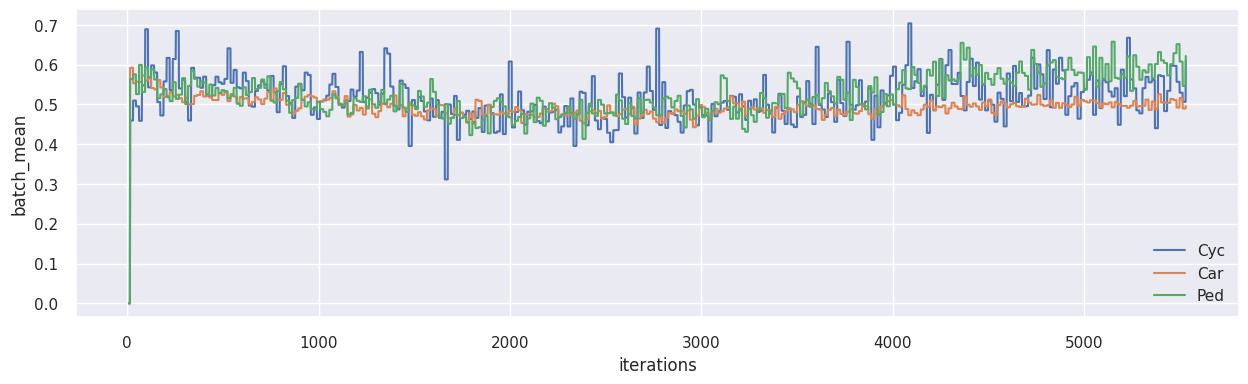

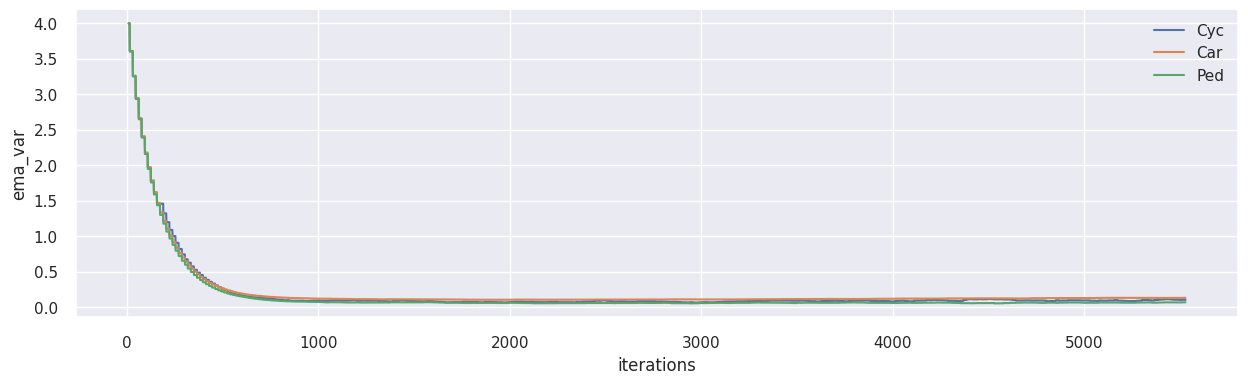

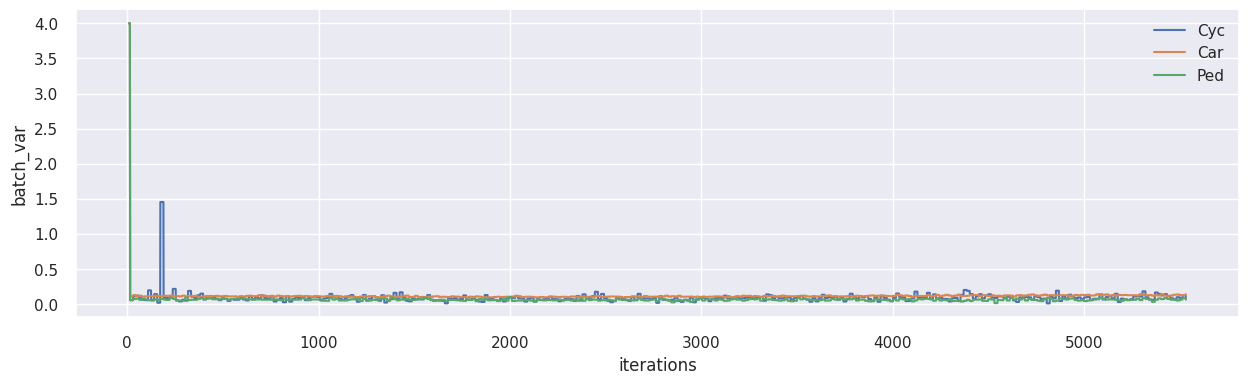

In [8]:
def utils():    
    sns.set_theme(style="darkgrid", rc={
                                    'xtick.bottom': False,
                                    'ytick.left': False,
                                    })      
    f, axes = plt.subplots(1, 1, sharey=True, figsize=(15,4))
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    p = sns.color_palette('rocket_r')
    print(len(p))
    palette = {'Car': p[0], 'Pedestrian':p[3], 'Cyclist': p[5]}
    ema_alpha = 0.10
def plot_softmatch(df,keys=[]):
    scale_keys = ['ema_var','batch_var']
    for key in keys:
        cls =[]
                   
        for i in range(0,len(df[key]),3):
            # print(i)
            if key in scale_keys:
                sub_list = []
                sub_list.append(4*df[key][i])
                sub_list.append(4*df[key][i+1])
                sub_list.append(4*df[key][i+2])
                cls.append(sub_list)
            else:
                sub_list = []
                sub_list.append(df[key][i])
                sub_list.append(df[key][i+1])
                sub_list.append(df[key][i+2])
                cls.append(sub_list)
        col = ['Car','Ped','Cyc']
        iou_thresh = pd.DataFrame(cls,columns=col)[10:]
        utils()
        sns.lineplot(data=iou_thresh, x=iou_thresh.index, y="Cyc", label="Cyc")
        sns.lineplot(data=iou_thresh, x=iou_thresh.index, y="Car", label="Car")
        sns.lineplot(data=iou_thresh, x=iou_thresh.index, y="Ped", label="Ped")
        plt.xlabel('iterations')
        plt.ylabel(key)
        plt.legend() # add the legend box

    
    plt.show()
keys = ['ema_mean','batch_mean','ema_var','batch_var']
plot_softmatch(subsample,keys=keys)

6
6
6
6


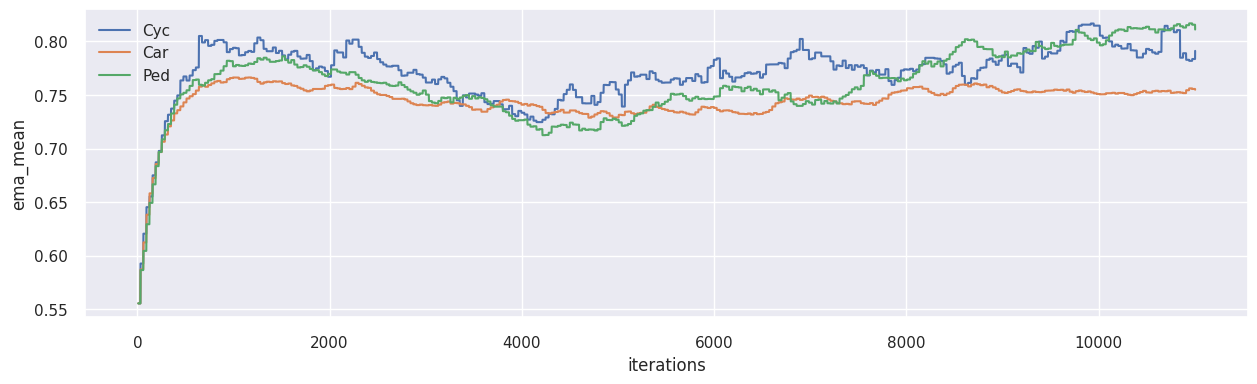

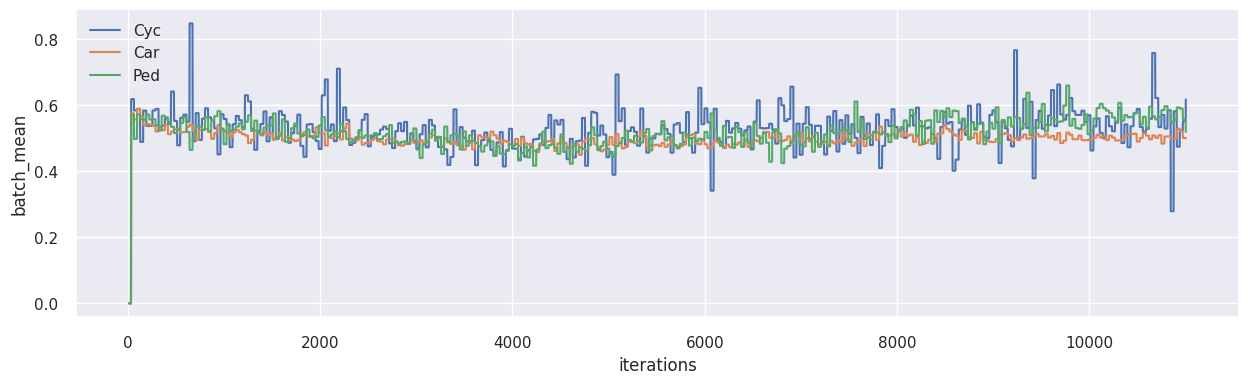

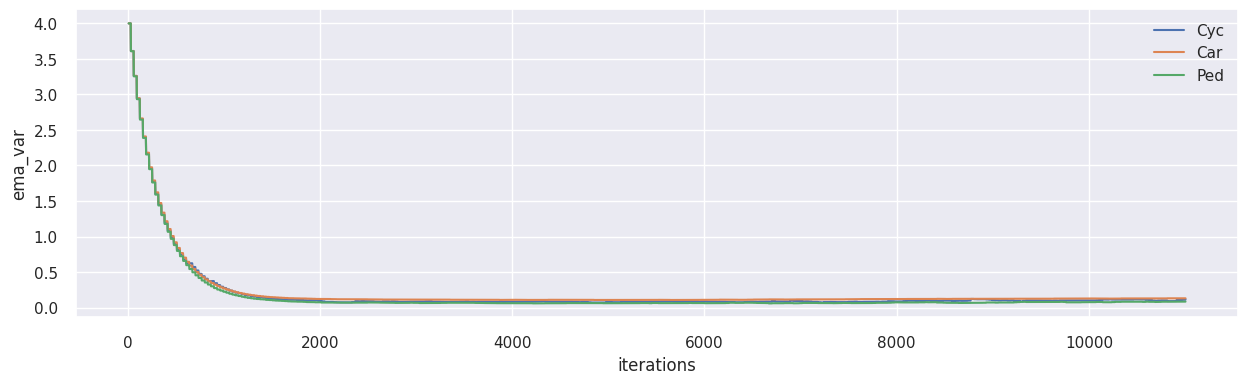

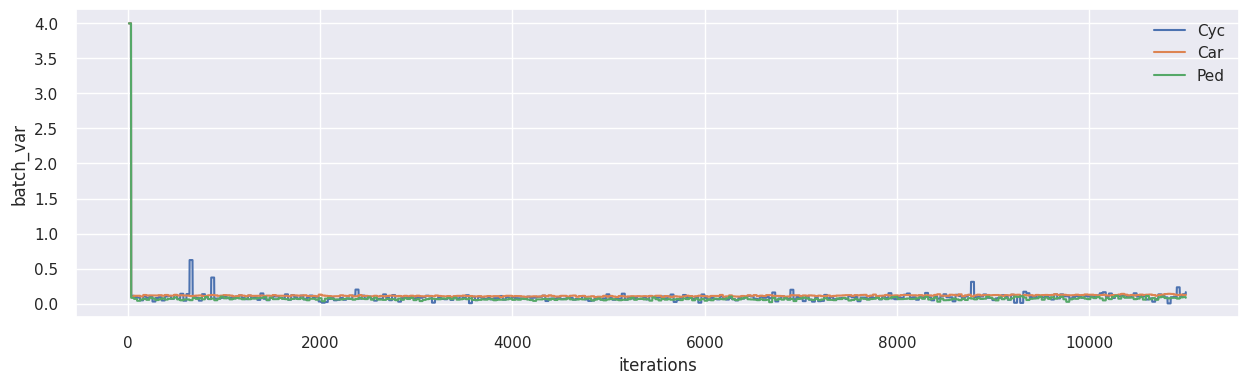

In [9]:
plot_softmatch(scores_6,keys)

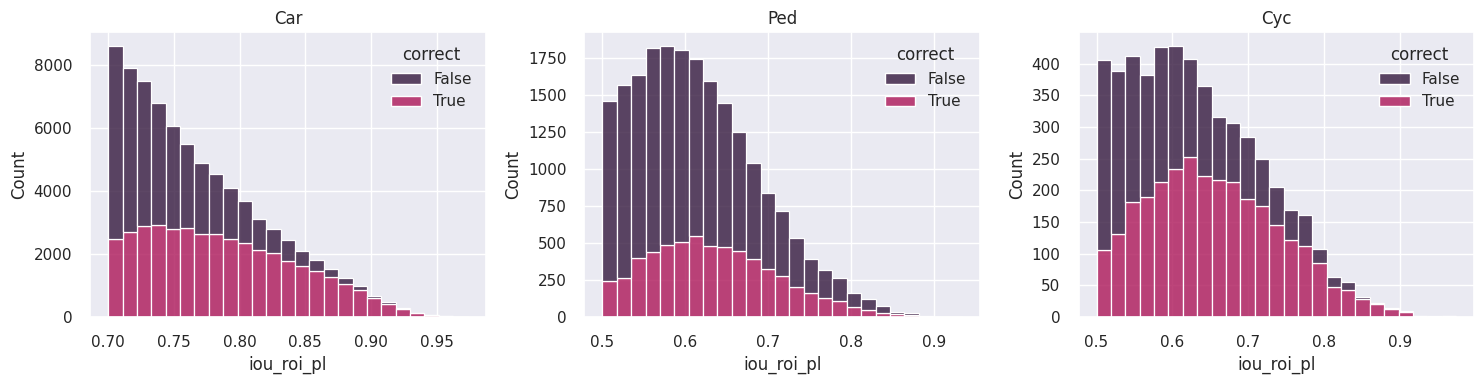

In [13]:
def utils(i):
    sns.set_theme(style="darkgrid")

    p = sns.color_palette('rocket')
    palette = [p[1],p[2]]
    f, axes = plt.subplots(i,3, figsize=(15,4))
    
def tp_fp(dfs=[]):
    # utils(len(dfs))
    sns.set_theme(style="darkgrid")
    # p = sns.cubehelix_palette(rot=-.90)
    p = sns.color_palette('rocket')
    palette = [p[0],p[2]]
    f, axes = plt.subplots(len(dfs),3, figsize=(15,4))
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask
    for i,df in enumerate(dfs):
        scores = {
            'iou_roi_gt': df['iou_roi_gt'],
            'iou_roi_pl': df['iou_roi_pl'],
            'iteration' : df['iteration'],
            'class_labels': df['class_labels']
        }
        scores_df = pd.DataFrame(scores)
        
        scores_cls = []
        cls = ['Car','Ped','Cyc']
        for i in range(0,3):
            mask = (scores_df['class_labels'] == i+1) & (scores_df['iou_roi_pl'] >= fg_thresh[i]) 
            scores_cls.append(scores_df[mask])
            scores_cls[i]['correct'] = scores_cls[i]['iou_roi_gt'].apply(lambda x: x >= fg_thresh[i])
            sns.histplot(ax=axes[i],data=scores_cls[i], x="iou_roi_pl", hue="correct", fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=25, palette=palette, alpha=0.8)
            # sns.lineplot()
            axes[i].set_title(label = cls[i])
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        f.savefig(fname=f"dist_all.pdf", transparent=False, bbox_inches='tight')
    plt.show()
dfs = [iou3d] 
tp_fp(dfs)

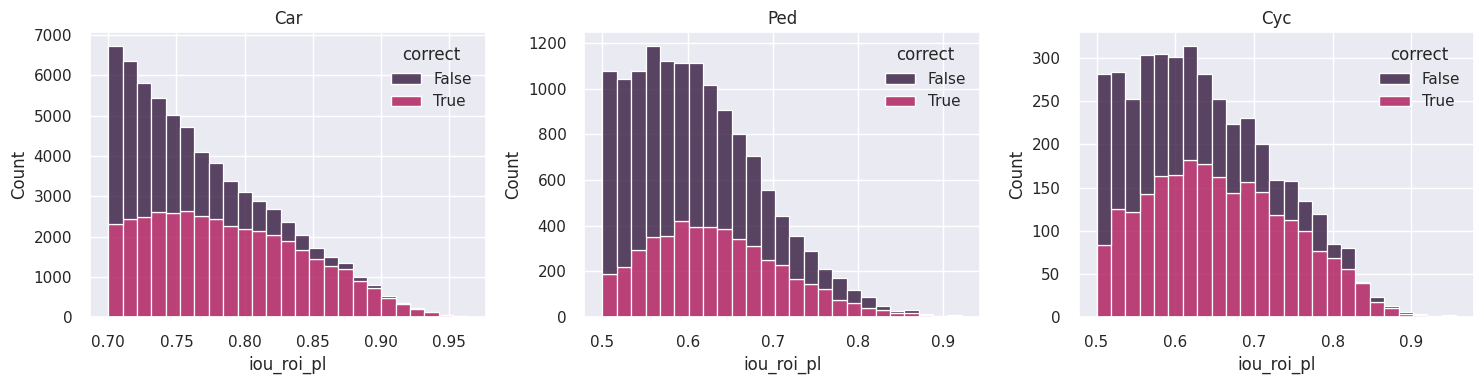

In [14]:
tp_fp([scores_6])

In [13]:
len(scores_6['ema_mean']) 

33018

#### Generating TP and FP based on dynamic softmatch thresholds

In [15]:
cls=[]
var=[]
temp = []
temp_v = []
key='ema_mean'
for i in range(0,len(scores_6[key]),3):
    # print(i)
    sub_list = []
    sub_list.append(scores_6[key][i])
    sub_list.append(scores_6[key][i+1])
    sub_list.append(scores_6[key][i+2])
    cls.append(sub_list)
key = 'ema_var'
for i in range(0,len(scores_6[key]),3):
    # print(i)
    sub_list = []
    sub_list.append(scores_6[key][i])
    sub_list.append(scores_6[key][i+1])
    sub_list.append(scores_6[key][i+2])
    var.append(sub_list)

col = ['Car','Ped','Cyc']
means = pd.DataFrame(cls,columns=col)
vars = pd.DataFrame(var,columns=col)
iteration = [int(x) for x in scores_6['iteration']]
scores_6['iteration'] = iteration

for i,x in enumerate(scores_6['iteration']):
    temp.append(means.iloc[x][scores_6['class_labels'][i]-1])
    temp_v.append(vars.iloc[x][scores_6['class_labels'][i]-1])
scores = {
    'iou_roi_gt': scores_6['iou_roi_gt'],
    'iou_roi_pl': scores_6['iou_roi_pl'],
    'iteration' : scores_6['iteration'],
    'class_labels': scores_6['class_labels'],
    'threshold': temp,
    'softmatch_weights': scores_6['softmatch_weights'],
    'weights': scores_6['weights'],
    'var':temp_v
}
thresh_scores = pd.DataFrame(scores)

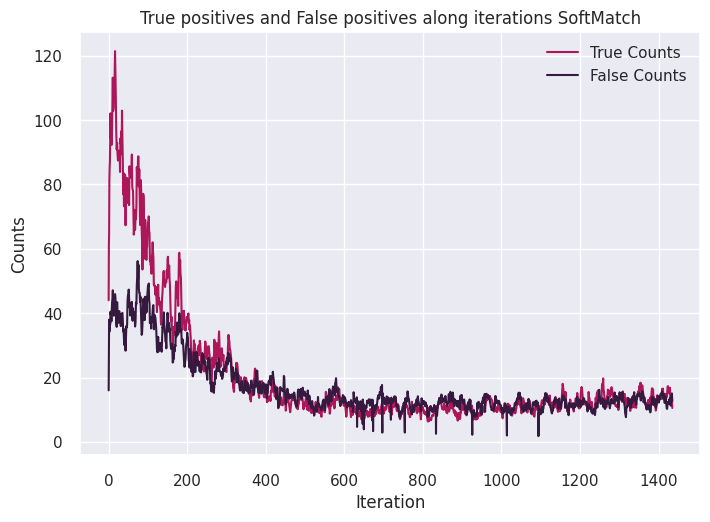

In [15]:
thresh_scores['correct'] = (thresh_scores['iou_roi_gt'] > thresh_scores['threshold']) & (thresh_scores['iou_roi_pl'] > thresh_scores['threshold'])
thresh_scores['filtered_wrt_pl'] = (thresh_scores['iou_roi_pl'] >= thresh_scores['threshold'])
filtered_thresh_df = thresh_scores[thresh_scores['filtered_wrt_pl'] == True]
true_counts = filtered_thresh_df[filtered_thresh_df['correct'] == True]['iteration'].value_counts().sort_index()
false_counts = filtered_thresh_df[filtered_thresh_df['correct'] == False]['iteration'].value_counts().sort_index()

# Convert true_counts to DataFrame
true_counts_df = true_counts.reset_index()
true_counts_df.columns = ['iteration', 'True_positives']

# Convert false_counts to DataFrame
false_counts_df = false_counts.reset_index()
false_counts_df.columns = ['iteration', 'False_positives']

# Merge true_counts_df and false_counts_df into a new DataFrame
tp_fp_df = pd.merge(true_counts_df, false_counts_df, on='iteration', how='outer')
# Plot line plot for true_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='True_positives', label='True Counts',color=p[2])

# Plot line plot for false_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='False_positives',label='False Counts',color=p[0])

# Set axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Counts')
plt.title('True positives and False positives along iterations SoftMatch')

# Add legend
plt.legend()

# Show the plot
plt.show()


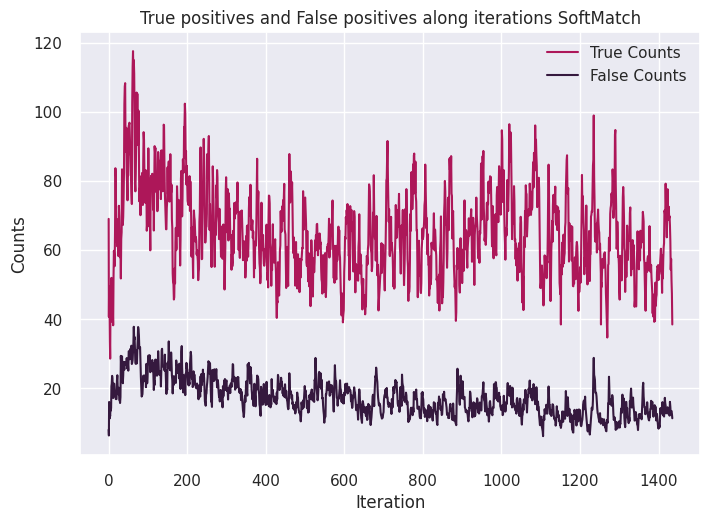

In [16]:
cls=[]
var=[]
temp = []
temp_v = []
key='ema_mean'
for i in range(0,len(subsample[key]),3):
    # print(i)
    sub_list = []
    sub_list.append(subsample[key][i])
    sub_list.append(subsample[key][i+1])
    sub_list.append(subsample[key][i+2])
    cls.append(sub_list)
key = 'ema_var'
for i in range(0,len(subsample[key]),3):
    # print(i)
    sub_list = []
    sub_list.append(subsample[key][i])
    sub_list.append(subsample[key][i+1])
    sub_list.append(subsample[key][i+2])
    var.append(sub_list)

col = ['Car','Ped','Cyc']
means = pd.DataFrame(cls,columns=col)
vars = pd.DataFrame(var,columns=col)
iteration = [int(x) for x in subsample['iteration']]
subsample['iteration'] = iteration

for i,x in enumerate(subsample['iteration']):
    temp.append(means.iloc[x][subsample['class_labels'][i]-1])
    temp_v.append(vars.iloc[x][subsample['class_labels'][i]-1])
scores = {
    'iou_roi_gt': subsample['iou_roi_gt'],
    'iou_roi_pl': subsample['iou_roi_pl'],
    'iteration' : subsample['iteration'],
    'class_labels': subsample['class_labels'],
    'threshold': temp,
    'softmatch_weights': subsample['softmatch_weights'],
    'weights': subsample['weights'],
    'var':temp_v
}
thresh_scores = pd.DataFrame(scores)
thresh_scores['correct'] = (thresh_scores['iou_roi_gt'] > thresh_scores['threshold']) & (thresh_scores['iou_roi_pl'] > thresh_scores['threshold'])
thresh_scores['filtered_wrt_pl'] = (thresh_scores['iou_roi_pl'] >= thresh_scores['threshold'])
filtered_thresh_df = thresh_scores[thresh_scores['filtered_wrt_pl'] == True]
true_counts = filtered_thresh_df[filtered_thresh_df['correct'] == True]['iteration'].value_counts().sort_index()
false_counts = filtered_thresh_df[filtered_thresh_df['correct'] == False]['iteration'].value_counts().sort_index()

# Convert true_counts to DataFrame
true_counts_df = true_counts.reset_index()
true_counts_df.columns = ['iteration', 'True_positives']

# Convert false_counts to DataFrame
false_counts_df = false_counts.reset_index()
false_counts_df.columns = ['iteration', 'False_positives']

# Merge true_counts_df and false_counts_df into a new DataFrame
tp_fp_df = pd.merge(true_counts_df, false_counts_df, on='iteration', how='outer')
# Plot line plot for true_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='True_positives', label='True Counts',color=p[2])

# Plot line plot for false_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='False_positives',label='False Counts',color=p[0])

# Set axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Counts')
plt.title('True positives and False positives along iterations SoftMatch')

# Add legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


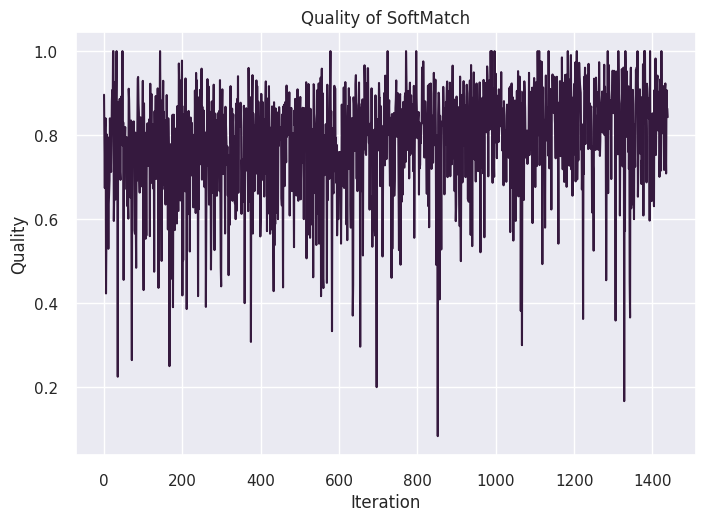

In [17]:
# consider iou_wrt_pl passing the threshold
sum_weights = filtered_thresh_df.groupby('iteration')['weights'].sum()
filtered_df_tp = filtered_thresh_df[filtered_thresh_df['correct'] == True]
true_counts = filtered_df_tp['iteration'].value_counts().sort_index()
tp_weights = filtered_df_tp.groupby('iteration')['weights'].sum()
sum_weights = filtered_thresh_df.groupby('iteration')['weights'].sum()
quality = tp_weights/sum_weights
tp_fp_df['quality'] = quality
# sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='True_positives', label='True Counts',color=p[2])

# Plot line plot for false_counts
sns.lineplot(data=tp_fp_df, x='iteration', y='quality',color=p[0])

# Set axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Quality')
plt.title('Quality of SoftMatch')

# Add legend
plt.legend()

# Show the plot
plt.show()

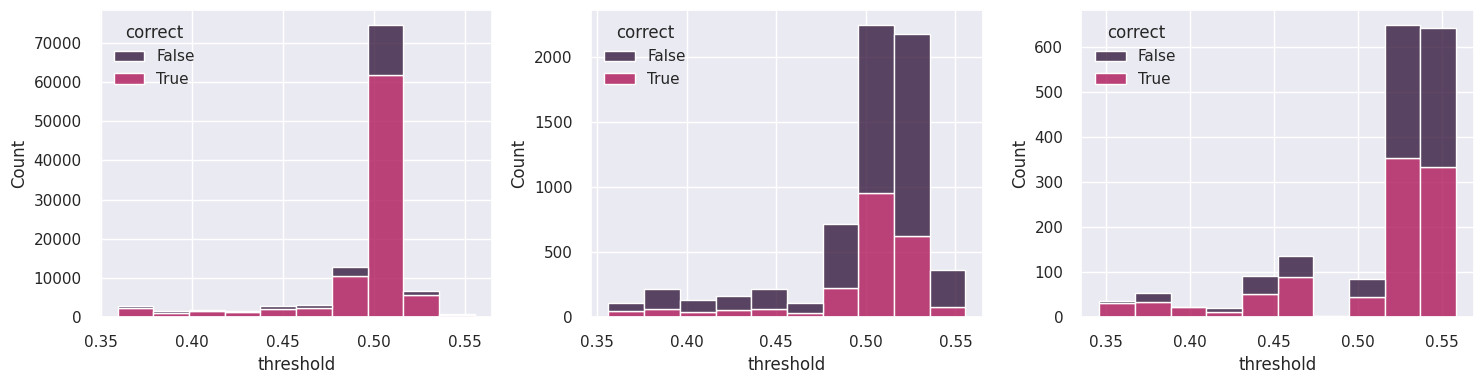

In [18]:
def plot_thresh_tp_fp(df):
    # utils(len(dfs))
    sns.set_theme(style="darkgrid")
    # p = sns.cubehelix_palette(rot=-.90)
    p = sns.color_palette('rocket')
    palette = [p[0],p[2]]
    f, axes = plt.subplots(len(dfs),3, figsize=(15,4))


    for i in range(0,3):
        sns.histplot(ax=axes[i],data=df[df['class_labels'] == i+1], x="threshold", hue="correct", fill=True, kde=False,stat='count',multiple="stack", bins=10, palette=palette, alpha=0.8)
        # sns.lineplot()
        # axes[i].set_title(label = cls[i])
    f.tight_layout()
    f.subplots_adjust(wspace=0.25, hspace=0.2)
    f.savefig(fname=f"dist_all.pdf", transparent=False, bbox_inches='tight')
    plt.show()

plot_thresh_tp_fp(filtered_thresh_df)

In [20]:
p = sns.color_palette('rocket')
palette = [p[0],p[2]]

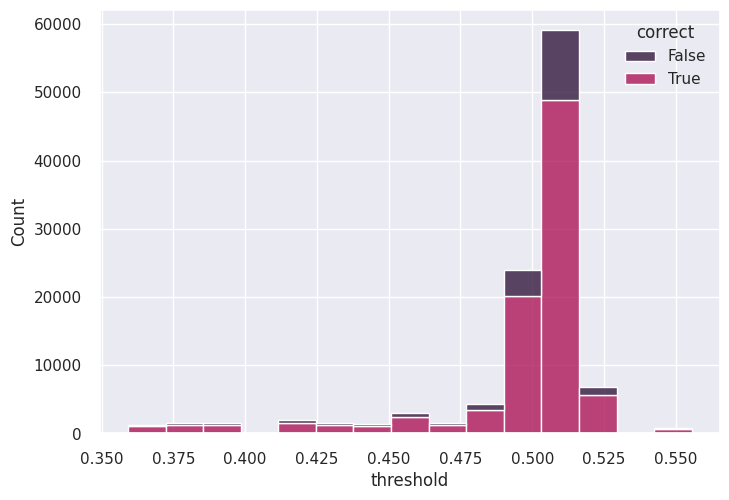

In [21]:
sns.histplot(data=filtered_thresh_df[filtered_thresh_df['class_labels'] == 1], x="threshold", hue="correct", fill=True, kde=False,stat='count',multiple="stack", bins=15, palette=palette, alpha=0.8)
plt.show()

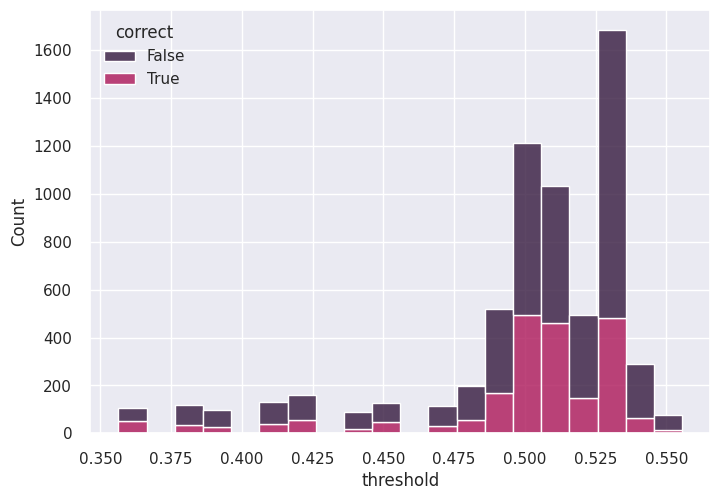

In [22]:
sns.histplot(data=filtered_thresh_df[filtered_thresh_df['class_labels'] == 2], x="threshold", hue="correct", fill=True, kde=False,stat='count',multiple="stack", bins=20, palette=palette, alpha=0.8)
plt.show()

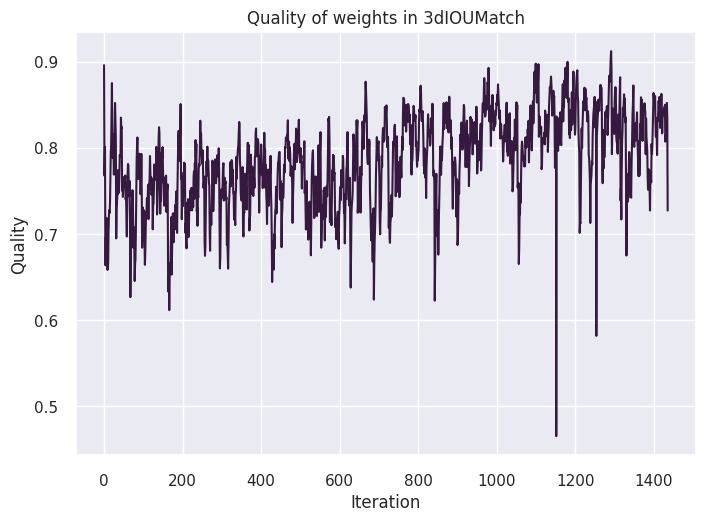

In [23]:

tp_fp_df['True_positives'].fillna(0.0, inplace=True)
tp_fp_df['False_positives'].fillna(0.0, inplace=True)
tp_fp_df['weight_sum'] = sum_weights
sum = tp_fp_df['True_positives'] + tp_fp_df['False_positives']
quality = tp_fp_df['True_positives'] / sum
tp_fp_df['quality'] = quality
# Plot line plot for false_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='quality',color=p[0])

# Set axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Quality')
plt.title('Quality of weights in 3dIOUMatch')
plt.show()

#### Generating TP and FP based on 3diouMatch Threshold FG = 0.75

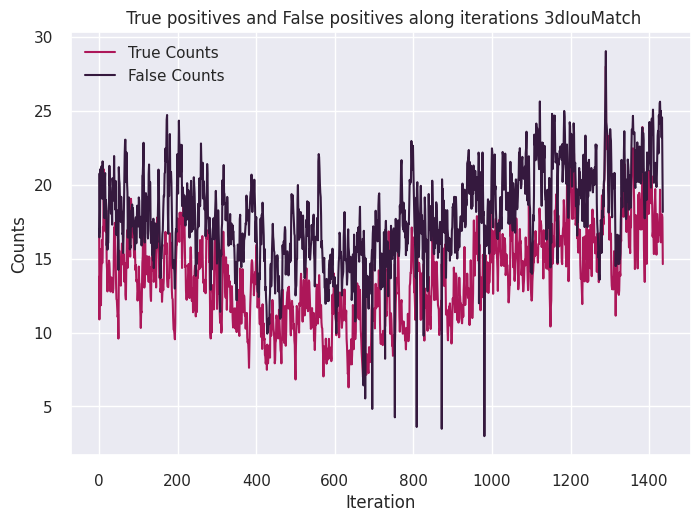

In [24]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
}
thresh_3diou = pd.DataFrame(scores)
thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] > 0.75) & (thresh_3diou['iou_roi_pl'] > 0.75)
thresh_3diou['filtered_wrt_pl'] = (thresh_3diou['iou_roi_pl'] > 0.75)
filtered_thresh_df = thresh_3diou[thresh_3diou['filtered_wrt_pl'] == True]
true_counts = filtered_thresh_df[filtered_thresh_df['correct'] == True]['iteration'].value_counts().sort_index()
false_counts = filtered_thresh_df[filtered_thresh_df['correct'] == False]['iteration'].value_counts().sort_index()

# Convert true_counts to DataFrame
true_counts_df = true_counts.reset_index()
true_counts_df.columns = ['iteration', 'True_positives']

# Convert false_counts to DataFrame
false_counts_df = false_counts.reset_index()
false_counts_df.columns = ['iteration', 'False_positives']

# Merge true_counts_df and false_counts_df into a new DataFrame
tp_fp_df = pd.merge(true_counts_df, false_counts_df, on='iteration', how='outer')
# Plot line plot for true_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='True_positives', label='True Counts',color=p[2])

# Plot line plot for false_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='False_positives',label='False Counts',color=p[0])

# Set axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Counts')
plt.title(' True positives and False positives along iterations 3dIouMatch')

# Add legend
plt.legend()

# Show the plot
plt.show()

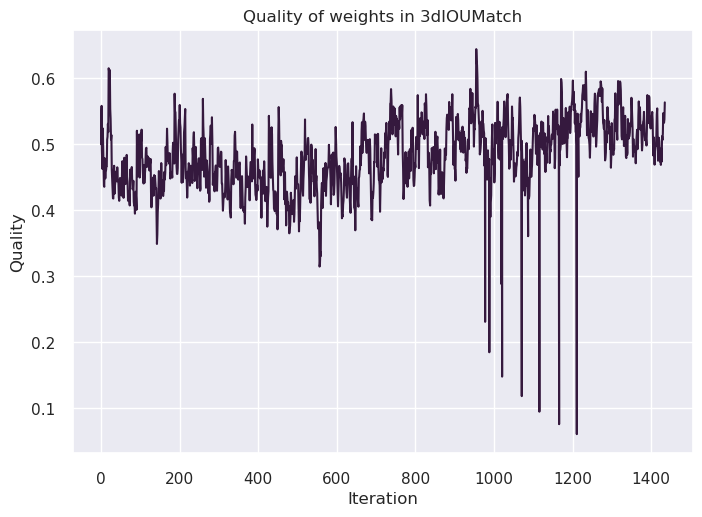

In [250]:
tp_fp_df['True_positives'].fillna(0.0, inplace=True)
tp_fp_df['False_positives'].fillna(0.0, inplace=True)
sum = tp_fp_df['True_positives'] + tp_fp_df['False_positives']
quality = tp_fp_df['True_positives'] / sum
tp_fp_df['quality'] = quality
# Plot line plot for false_counts
sns.lineplot(data=tp_fp_df.ewm(alpha=0.2).mean(), x='iteration', y='quality',color=p[0])

# Set axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Quality')
plt.title('Quality of weights in 3dIOUMatch')
plt.show()

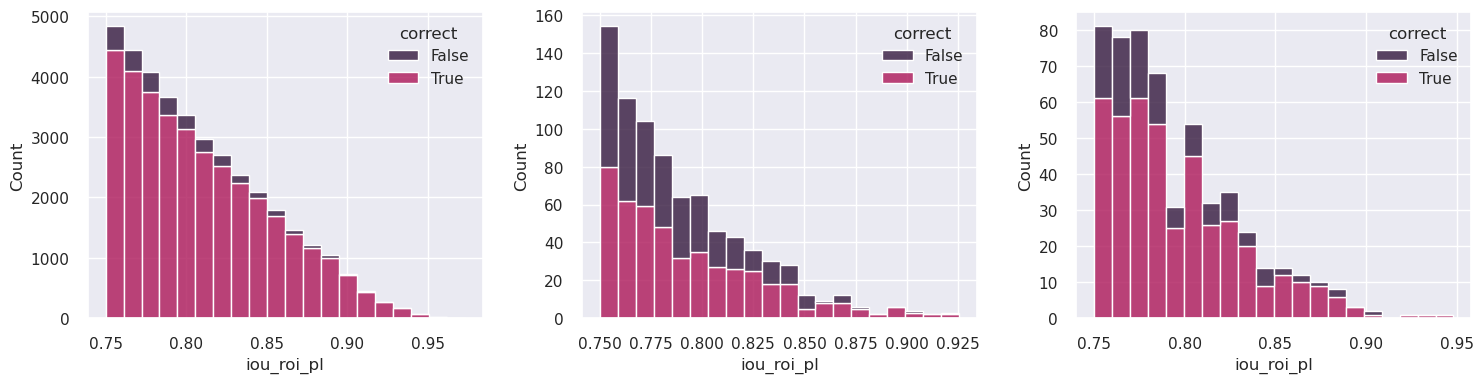

In [159]:
scores_cls = []
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
    mask = (thresh_3diou['class_labels'] == i+1) & (thresh_3diou['iou_roi_pl'] >= 0.5) 
    scores_cls.append(thresh_3diou[mask])
    sns.histplot(ax=axes[i],data=scores_cls[i], x="iou_roi_pl",hue='correct',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, palette=palette, alpha=0.8)
    #sns.lineplot(ax=axes[i],data=scores_cls[i], x=thresh_3diou.index,y="correct",palette=palette, alpha=0.8)
    f.tight_layout()
    f.subplots_adjust(wspace=0.25, hspace=0.2)
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [60]:
cls=[]
var=[]
temp = []
temp_v = []
key='ema_mean'
for i in range(0,len(softmatch_weights[key]),3):
    # print(i)
    sub_list = []
    sub_list.append(softmatch_weights[key][i])
    sub_list.append(softmatch_weights[key][i+1])
    sub_list.append(softmatch_weights[key][i+2])
    cls.append(sub_list)
key = 'ema_var'
for i in range(0,len(softmatch_weights[key]),3):
    # print(i)
    sub_list = []
    sub_list.append(softmatch_weights[key][i])
    sub_list.append(softmatch_weights[key][i+1])
    sub_list.append(softmatch_weights[key][i+2])
    var.append(sub_list)

col = ['Car','Ped','Cyc']
means = pd.DataFrame(cls,columns=col)
vars = pd.DataFrame(var,columns=col)
iteration = [int(x) for x in softmatch_weights['iteration']]
softmatch_weights['iteration'] = iteration

for i,x in enumerate(softmatch_weights['iteration']):
    temp.append(means.iloc[x][softmatch_weights['class_labels'][i]-1])
    temp_v.append(vars.iloc[x][softmatch_weights['class_labels'][i]-1])
scores = {
    'iou_roi_gt': softmatch_weights['iou_roi_gt'],
    'iou_roi_pl': softmatch_weights['iou_roi_pl'],
    'iteration' : softmatch_weights['iteration'],
    'class_labels': softmatch_weights['class_labels'],
    'threshold': temp,
    'softmatch_weights': softmatch_weights['softmatch_weights'],
    'var':temp_v
}
thresh_softmatch = pd.DataFrame(scores)
thresh_softmatch['correct'] = (thresh_softmatch['iou_roi_gt'] > thresh_softmatch['threshold']) & (thresh_softmatch['iou_roi_pl'] > thresh_softmatch['threshold'])

,iou_roi_gt,iou_roi_pl,iteration,class_labels,correct,filtered_wrt_pl
0,0.507045,0.721466,0.0,1,False,False
1,0.404484,0.597051,0.0,1,False,False
2,0.851217,0.845587,0.0,1,True,True
3,0.860345,0.877723,0.0,1,True,True
4,0.879351,0.868934,0.0,1,True,True
...,...,...,...,...,...,...
1410939,0.000000,0.000000,1439.0,1,False,False
1410940,0.000000,0.000000,1439.0,1,False,False
1410941,0.066790,0.000000,1439.0,3,False,False
1410942,0.000000,0.000000,1439.0,1,False,False


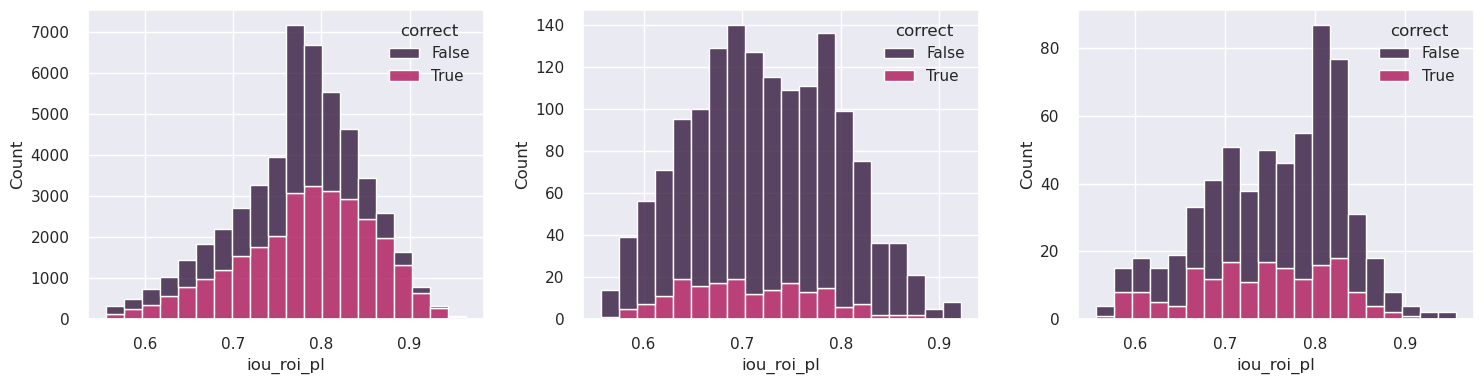

In [155]:
scores_cls = []
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
    mask = (thresh_softmatch['class_labels'] == i+1) & (thresh_softmatch['iou_roi_pl'] >= thresh_softmatch['threshold']) 
    scores_cls.append(thresh_softmatch[mask])
    sns.histplot(ax=axes[i],data=scores_cls[i], x="iou_roi_pl",hue='correct',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, palette=palette, alpha=0.8)
    #sns.lineplot(ax=axes[i],data=scores_cls[i], x=thresh_softmatch.index,y="correct",palette=palette, alpha=0.8)
    f.tight_layout()
    f.subplots_adjust(wspace=0.25, hspace=0.2)
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [25]:
scores_6['softmatch_weights']
filtered_list = [x for x in scores_6['softmatch_weights'] if x <0.25]

##  (Fig 4) % of FG IoUs crossing local thresh using Barplot

In [27]:
thresh_softmatch

NameError: name 'thresh_softmatch' is not defined

In [20]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, class_name, disable_marginal_plot=True):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.disable_marginal_plot = disable_marginal_plot
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid(class_name)
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self, class_name):
        """ Move Jointgrid """
        self.sg.ax_joint.set_title(class_name, fontsize=14)
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        # disable marginal plots 
        if not self.disable_marginal_plot:
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])
        
        left_pos = 0.97 if self.disable_marginal_plot else 1
        # Make space for the colorbar
        self.fig.subplots_adjust(right=1.2)
        # Define a new Axes where the colorbar will go
        cax = self.fig.add_axes([left_pos, 0.1, .01, 0.80])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        self.fig.colorbar(points, cax=cax).set_label("$w_{i}$", fontsize=16)

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint", epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = 1439-(24*epoch_num)

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask #& ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5)
        plt.show()
    else:
        if fig_title=='Before':
            color = _cmap(1)
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", color=color, xlim=-0.01, ylim=-0.01, legend=True, palette="rocket_r", s=10)
        else:
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', xlim=-0.01, ylim=-0.01, legend=False, palette="rocket_r", s=10)
        g.set_axis_labels('$u_{i}$', '$v_{i}$', fontsize=16)
    
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), lw=2)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\Delta_{c}=var$".replace('var', str(gt_thresh['FG'][class_name])), lw=2)
        # plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)

        legend = plt.legend(bbox_to_anchor=(0.22, 1), frameon=True, fontsize=12, loc='upper center', borderpad=0.2, framealpha = 0.7) #'lower left'
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)
        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.96, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        g.fig.colorbar(points, cax=cax).set_label("Weights")
        # plt.show()
    return g

car_plot_before = get_joint_plot(df2, 'Car', "Before", epoch_num=0.50)
car_plot_after = get_joint_plot(df, 'Car', "After", epoch_num=0.50)

ped_plot_before = get_joint_plot(df2, 'Pedestrian', "Before", epoch_num=14)
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After", epoch_num=14)

cyc_plot_before = get_joint_plot(df2, 'Cyclist', "Before", epoch_num=24)
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After", epoch_num=24)

fig = plt.figure(figsize=(13,4))
gs = gridspec.GridSpec(1, 3)

# disable the marginal plots using this flag
disable_marginal_plot = True
#before
# mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0], disable_marginal_plot)
# mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1], disable_marginal_plot)
# mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2], disable_marginal_plot)
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[0], 'Car', disable_marginal_plot)
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[1], 'Pedestrian', disable_marginal_plot)
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[2], 'Cyclist', disable_marginal_plot)

gs.tight_layout(fig)
fig.savefig(fname="ious_weights.pdf", transparent=False, bbox_inches='tight')
plt.show()


IndexError: The shape of the mask [710656] at index 0 does not match the shape of the indexed tensor [0] at index 0

## (Fig 3) KDE Plot for IoUs wrt PL and GT for all the samples 
#### (over last 10 epochs)

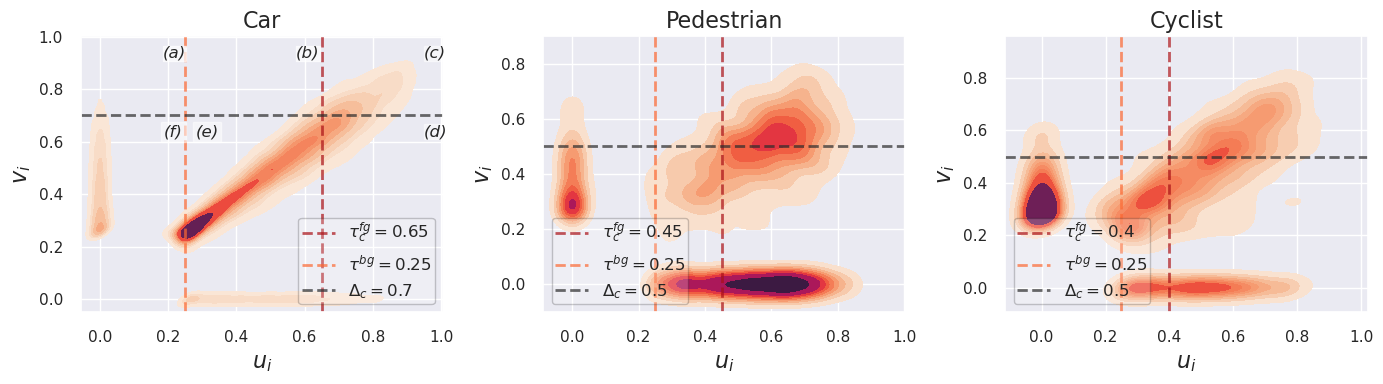

In [ ]:
def get_kde_plot(df, class_name, ax, epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = (1439-(24*epoch_num)) if epoch_num != None else 0
#     start_iter = (24*epoch_num) if epoch_num != None else 0

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter 
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < gt_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask
 
    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})
# add title to kde plot
    ax.set_title(class_name, fontsize=16)
    sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5, ax=ax)

    ax.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    ax.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
    ax.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-1], label="$\\Delta_{c}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    # ax.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)
    ax.set_xlabel('$u_{i}$', fontsize=16)
    ax.set_ylabel('$v_{i}$', fontsize=16)
    if class_name=='Car':
        legend_loc = "lower right"
    else:
        legend_loc = "lower left"
    legend = ax.legend(frameon=True, fontsize=12, loc=legend_loc, borderpad=0.2, framealpha = 0.2)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    
    if class_name=='Car':
        edge_color = 'white'
        ax.text(0.184, 0.92, '(a)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.575, 0.92, '(b)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.95, 0.92, '(c)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.95, 0.62, '(d)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.28, 0.62, '(e)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})
        ax.text(0.188, 0.62, '(f)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})


fig, axes = plt.subplots(1, 3, figsize=(14, 4))

get_kde_plot(df, 'Car', epoch_num=10, ax=axes[0]) # 0.5
get_kde_plot(df, 'Pedestrian', epoch_num=10, ax=axes[1]) #14
get_kde_plot(df, 'Cyclist', epoch_num=10, ax=axes[2]) #24

fig.tight_layout()
fig.savefig(fname="ious_kde.pdf", transparent=False, bbox_inches='tight')
plt.show()

In [5]:
iou3d

{'iou_roi_pl': [0.721466064453125,
  0.5970506072044373,
  0.8455870151519775,
  0.8777228593826294,
  0.8689344525337219,
  0.7963829040527344,
  0.6137910485267639,
  0.6333736777305603,
  0.8341050744056702,
  0.6463837623596191,
  0.7805420160293579,
  0.6411563754081726,
  0.7225695848464966,
  0.6614428758621216,
  0.8336058259010315,
  0.6375932693481445,
  0.5820369720458984,
  0.7806932926177979,
  0.6773490309715271,
  0.6487241387367249,
  0.6920511722564697,
  0.5983745455741882,
  0.637793242931366,
  0.5967766642570496,
  0.7175130844116211,
  0.8266676068305969,
  0.6976544857025146,
  0.6597009301185608,
  0.7067617177963257,
  0.654008686542511,
  0.6221020817756653,
  0.6685375571250916,
  0.6537536978721619,
  0.5751529932022095,
  0.5895617604255676,
  0.608338475227356,
  0.6314640641212463,
  0.7849719524383545,
  0.6683675050735474,
  0.689891517162323,
  0.5485582947731018,
  0.47676724195480347,
  0.5360817909240723,
  0.2992102801799774,
  0.4081818759441376,


In [50]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores'],
    'roi_scores': iou3d['roi_scores'],    
    'threshold': 0.75
}
iou3d_df = pd.DataFrame(scores)

In [ ]:
scores_old = {
    'iou_roi_gt': iou3d_old_thresh['iou_roi_gt'],
    'iou_roi_pl': iou3d_old_thresh['iou_roi_pl'],
    'iteration' : iou3d_old_thresh['iteration'],
    'class_labels': iou3d_old_thresh['class_labels'],
    'pred_scores': iou3d_old_thresh['pred_scores'],
    'roi_scores': iou3d_old_thresh['roi_scores'],    
    'threshold': 0.75
}
iou3d_ot_df = pd.DataFrame(scores_old)

In [62]:
iou3d_df['correct'] = (iou3d_df['iou_roi_pl'] >= 0.75) &  (iou3d_df['iou_roi_gt'] >= 0.75)
iou3d_df['correct_pred'] = (iou3d_df['pred_scores'] >= 0.75) &  (iou3d_df['iou_roi_gt'] >= 0.75)
iter_df = iou3d_df[iou3d_df['iteration']==0.0]

In [47]:
sns.cubehelix_palette(start=.5, rot=-.5)

[[0.7611058395410276, 0.897713045748989, 0.8454349452836011],
 [0.5692057725623613, 0.769825774304614, 0.7713170213730839],
 [0.4400101343169528, 0.6073546865542835, 0.7116827253370498],
 [0.36445067068963477, 0.4310083919724144, 0.6158403898540434],
 [0.29790922210725757, 0.2562451006147689, 0.45126193989070634],
 [0.19219588654040817, 0.11144874684946916, 0.2327834607416993]]